In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/sme-invoicing-assistant


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/sme-invoicing-assistant/.env


True

In [4]:
results_mapping = {
    "RTX A6000": {
        "qwen2.5:7b": "results/llama3.2-vision_11b-qwen2.5_7b",
        "functionary-small": "results/llama3.2-vision_11b-functionary-small",
        "qwen2.5:32b": "results/llama3.2-vision_11b-qwen2.5_32b",
        "functionary-medium": "results/llama3.2-vision_11b-functionary-medium",
        "qwen2.5:72b": "results/llama3.2-vision_11b-qwen2.5_72b",
    },
    "RTX 4090": {
        "qwen2.5:7b": "results/llama3.2-vision_11b-qwen2.5_7b-RTX4090",
        "functionary-small": "results/llama3.2-vision_11b-functionary-small-RTX4090",
    },
    "OpenAI": {
        "gpt-4o-mini": "results/gpt-4o-mini-gpt-4o-mini",
        "gpt-4o": "results/gpt-4o-gpt-4o",
    },
}

In [5]:
import pandas as pd


def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()

In [ ]:
from src.misc.metrics import *

# Define index for the non-metric columns
index = ["platform", "model"]

# Initialize an empty DataFrame
metrics_df = pd.DataFrame()

# Process results and populate the DataFrame
for platform, results in results_mapping.items():
    for model, result in results.items():
        db_filepath = f"{result}/emails.db"
        metrics = calculate_metrics(db_filepath)
        df = metrics["df"]
        metrics = get_metrics(df)
        results_mapping[platform][model] = df

        if platform != "OpenAI":
            power = total_power_in_watt(
                f"{result}/power_with_vision.csv"
            )  # + total_power_in_watt(f"{result}/power_without_vision.csv")
            # power /= 2

            idle_power_csv = f"results/power_idle_{platform}.csv"
            if not Path(idle_power_csv).exists():
                idle_power_csv = "results/power_idle.csv"
            power -= total_power_in_watt(idle_power_csv)

            metrics["power"] = power

        # Add non-metric columns and metrics to a single dictionary
        row_data = {"platform": platform, "model": model, **metrics}
        metrics_df = pd.concat(
            [metrics_df, pd.DataFrame([row_data])], ignore_index=True
        )

metrics_df

,platform,model,task_completion_rate,task_success_rate,mean_execution_time,total_tasks,SUCCESS,ERROR,NO_INVOICE,power
0,RTX A6000,qwen2.5:7b,1,0.858586,11.295402,990,850,136,4,288.3550
1,RTX A6000,functionary-small,1,0.884848,1.734658,990,876,6,108,288.3550
2,RTX A6000,qwen2.5:32b,1,0.998990,12.947549,990,989,1,0,299.8840
3,RTX A6000,functionary-medium,1,0.941414,18.798024,990,932,11,47,284.6410
4,RTX A6000,qwen2.5:72b,1,0.994949,68.134819,990,985,4,1,284.6410
5,RTX 4090,qwen2.5:7b,1,0.873737,21.020921,990,865,123,2,121.7782
6,RTX 4090,functionary-small,1,0.887879,3.568125,990,879,10,101,146.6126
7,OpenAI,gpt-4o-mini,1,0.976768,11.385764,990,967,21,2,NaN
8,OpenAI,gpt-4o,1,0.931313,11.128501,990,922,15,53,NaN


In [7]:
metrics_df["Energy per Task (Joules)"] = metrics_df["mean_execution_time"].astype(
    float
) * metrics_df["power"].astype(float)
metrics_df["Performance-to-Power Ratio (%/J)"] = (
    metrics_df["task_success_rate"].astype(float)
    * 100
    / metrics_df["Energy per Task (Joules)"].astype(float)
)
metrics_df

,platform,model,task_completion_rate,task_success_rate,mean_execution_time,total_tasks,SUCCESS,ERROR,NO_INVOICE,power,Energy per Task (Joules),Performance-to-Power Ratio (%/J)
0,RTX A6000,qwen2.5:7b,1,0.858586,11.295402,990,850,136,4,288.3550,3257.085540,0.026361
1,RTX A6000,functionary-small,1,0.884848,1.734658,990,876,6,108,288.3550,500.197347,0.176900
2,RTX A6000,qwen2.5:32b,1,0.998990,12.947549,990,989,1,0,299.8840,3882.762779,0.025729
3,RTX A6000,functionary-medium,1,0.941414,18.798024,990,932,11,47,284.6410,5350.688239,0.017594
4,RTX A6000,qwen2.5:72b,1,0.994949,68.134819,990,985,4,1,284.6410,19393.963069,0.005130
5,RTX 4090,qwen2.5:7b,1,0.873737,21.020921,990,865,123,2,121.7782,2559.889897,0.034132
6,RTX 4090,functionary-small,1,0.887879,3.568125,990,879,10,101,146.6126,523.132146,0.169724
7,OpenAI,gpt-4o-mini,1,0.976768,11.385764,990,967,21,2,NaN,NaN,NaN
8,OpenAI,gpt-4o,1,0.931313,11.128501,990,922,15,53,NaN,NaN,NaN


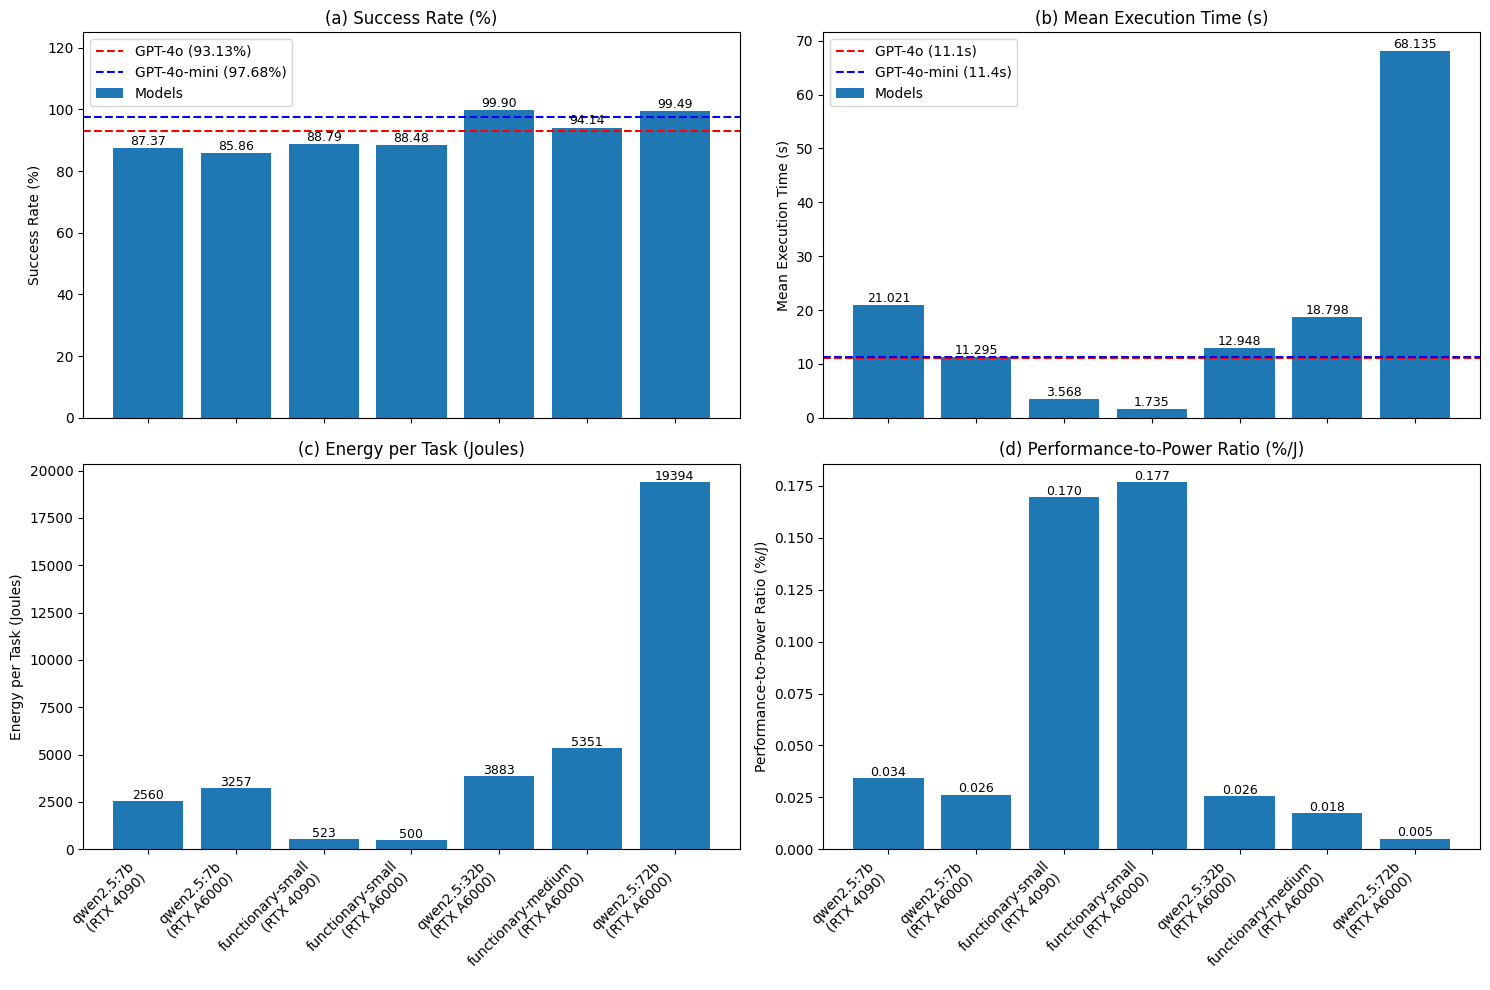

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = metrics_df[:-2].copy()

# Custom order for models by size and platform
model_order = {
    "qwen2.5:7b": 1,
    "functionary-small": 2,
    "qwen2.5:32b": 3,
    "functionary-medium": 4,
    "qwen2.5:72b": 5,
}
df["model_order"] = df["model"].map(model_order)
df["combined"] = df["model"] + "\n(" + df["platform"] + ")"
df = df.sort_values(by=["model_order", "platform"], ascending=[True, True])

# Setting up data for plotting
x_labels = df["combined"]
x_pos = np.arange(len(x_labels))

# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# First subplot: Success Rate
ax[0, 0].bar(
    x_pos, df["task_success_rate"] * 100, label="Models"
)  # Convert to percentage
ax[0, 0].set_title("(a) Success Rate (%)")
ax[0, 0].set_xticks(x_pos)
ax[0, 0].set_xticklabels([])
ax[0, 0].set_ylabel("Success Rate (%)")
ax[0, 0].set_ylim(0, 125)
for i, v in enumerate(df["task_success_rate"] * 100):
    ax[0, 0].text(i, v + 1, f"{v:.2f}", ha="center", fontsize=9)

# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
gpt_4o_success_rate = (
    metrics_df[metrics_df["model"] == "gpt-4o"].iloc[0]["task_success_rate"] * 100
)
gpt_4o_mini_success_rate = (
    metrics_df[metrics_df["model"] == "gpt-4o-mini"].iloc[0]["task_success_rate"] * 100
)
ax[0, 0].axhline(
    y=gpt_4o_success_rate,
    color="red",
    linestyle="--",
    label=f"GPT-4o ({gpt_4o_success_rate:.2f}%)",
)
ax[0, 0].axhline(
    y=gpt_4o_mini_success_rate,
    color="blue",
    linestyle="--",
    label=f"GPT-4o-mini ({gpt_4o_mini_success_rate:.2f}%)",
)
ax[0, 0].legend(loc="upper left")

# Second subplot: Mean Execution Time
ax[0, 1].bar(x_pos, df["mean_execution_time"], label="Models")
ax[0, 1].set_title("(b) Mean Execution Time (s)")
ax[0, 1].set_xticks(x_pos)
ax[0, 1].set_xticklabels([])
ax[0, 1].set_ylabel("Mean Execution Time (s)")
for i, v in enumerate(df["mean_execution_time"]):
    ax[0, 1].text(i, v + 0.5, f"{v:.3f}", ha="center", fontsize=9)
# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
gpt_4o_execution_time = metrics_df[metrics_df["model"] == "gpt-4o"].iloc[0][
    "mean_execution_time"
]
gpt_4o_mini_execution_time = metrics_df[metrics_df["model"] == "gpt-4o-mini"].iloc[0][
    "mean_execution_time"
]
ax[0, 1].axhline(
    y=gpt_4o_execution_time,
    color="red",
    linestyle="--",
    label=f"GPT-4o ({gpt_4o_execution_time:.1f}s)",
)
ax[0, 1].axhline(
    y=gpt_4o_mini_execution_time,
    color="blue",
    linestyle="--",
    label=f"GPT-4o-mini ({gpt_4o_mini_execution_time:.1f}s)",
)
ax[0, 1].legend(loc="upper left")

# Third subplot: Energy per Task (no overlay here)
ax[1, 0].bar(x_pos, df["Energy per Task (Joules)"])
ax[1, 0].set_title("(c) Energy per Task (Joules)")
ax[1, 0].set_xticks(x_pos)
ax[1, 0].set_xticklabels(x_labels, rotation=45, ha="right")
ax[1, 0].set_ylabel("Energy per Task (Joules)")
for i, v in enumerate(df["Energy per Task (Joules)"]):
    ax[1, 0].text(i, v + 100, f"{v:.0f}", ha="center", fontsize=9)

# Fourth subplot: Performance-to-Power Ratio (%/J) (no overlay here)
ax[1, 1].bar(x_pos, df["Performance-to-Power Ratio (%/J)"])
ax[1, 1].set_title("(d) Performance-to-Power Ratio (%/J)")
ax[1, 1].set_xticks(x_pos)
ax[1, 1].set_xticklabels(x_labels, rotation=45, ha="right")
ax[1, 1].set_ylabel("Performance-to-Power Ratio (%/J)")
for i, v in enumerate(df["Performance-to-Power Ratio (%/J)"]):
    ax[1, 1].text(i, v + 0.001, f"{v:.3f}", ha="center", fontsize=9)

# Layout adjustments
plt.tight_layout()
plt.show()

In [9]:
df = results_mapping["RTX A6000"]["qwen2.5:32b"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 0 to 989
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   email_id             990 non-null    object         
 1   sender_email         990 non-null    object         
 2   recipient_email      990 non-null    object         
 3   subject              990 non-null    object         
 4   email_body           990 non-null    object         
 5   attachments          990 non-null    object         
 6   process_status       990 non-null    object         
 7   response             990 non-null    object         
 8   start_time           990 non-null    datetime64[ns] 
 9   end_time             990 non-null    datetime64[ns] 
 10  total_time           990 non-null    object         
 11  successful_requests  990 non-null    object         
 12  total_tokens         990 non-null    object         
 13  prompt_tokens        990 

In [10]:
print_row_details(df[df["process_status"] == "ERROR"])

--------------------------------------------------
email_id: CE46356ACA7A447B9E43F5970CF29F56
--------------------------------------------------
sender_email: SamanthaMartin@example.com
--------------------------------------------------
recipient_email: tanya.official.456@gmail.com
--------------------------------------------------
subject: Payment Confirmation for Invoice ID: 10397
--------------------------------------------------
email_body: Hi Tanya ! Please find attached payment screenshot for Invoice ID: 10397 , Regards Samantha Martin
--------------------------------------------------
attachments: transaction_932.jpeg
--------------------------------------------------
process_status: ERROR
--------------------------------------------------
response: ERROR - The data engineer needs the invoice ID to proceed with the query, but it seems there is an ongoing issue where they are repeatedly asking for the same information despite being provided. Please check if there's a technical or